In [1]:
#Importation des Bibliotheques:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, metrics, utils
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import seaborn as sns
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [2]:
#Recuperation des donnees:
!pip install kaggle
from google.colab import files
files.upload()  # Ajout du fichier Kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri
!unzip brain-tumor-classification-mri.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Tes

________Training Set: _________
Classes: ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']
no_tumor: 395 images
pituitary_tumor: 827 images
meningioma_tumor: 822 images
glioma_tumor: 826 images


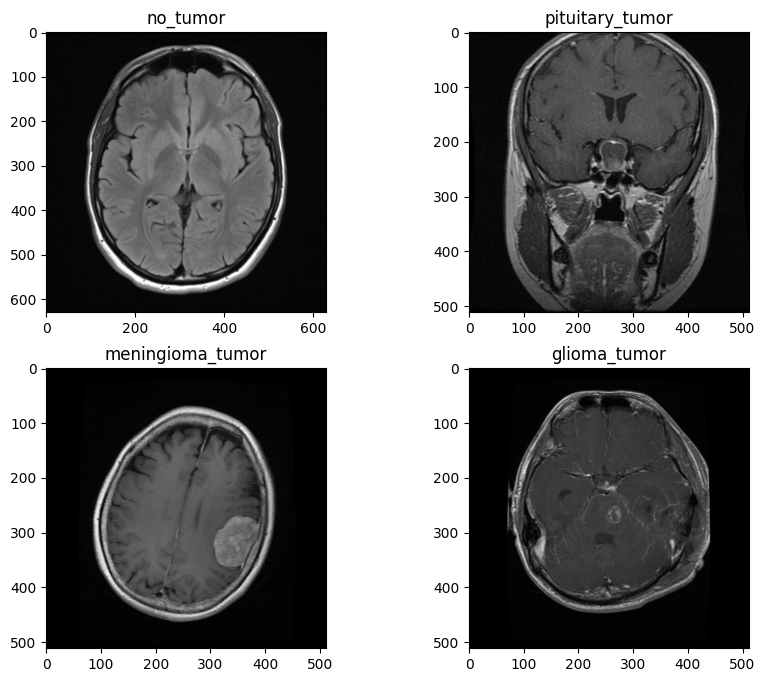

________Testing Set: _________
Classes: ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']
no_tumor: 105 images
pituitary_tumor: 74 images
meningioma_tumor: 115 images
glioma_tumor: 100 images


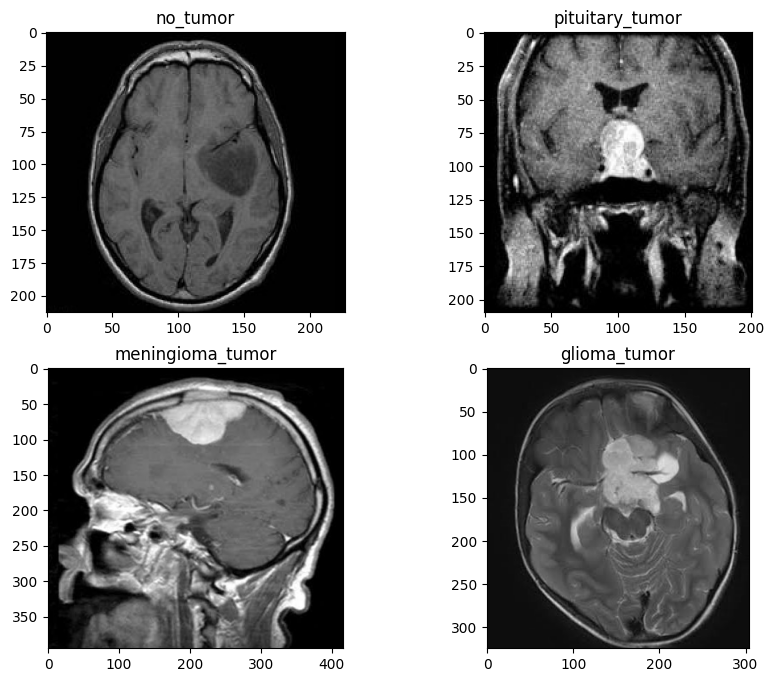

In [3]:
# Verification de l'installation:
# Cette section permet de vérifier le contenu des datasets d'entraînement et de test

#=== Training Set ===
# Définition du répertoire d'entraînement
data_dir_ = "/content/Training"
# Liste des classes (dossiers) dans le répertoire d'entraînement
classes_training = os.listdir(data_dir_)

# Affichage des informations sur le dataset d'entraînement
print("________Training Set: _________")
print("Classes:", classes_training)

# Affichage du nombre d'images par classe dans le training set
for cls in classes_training:
    print(f"{cls}: {len(os.listdir(os.path.join(data_dir_, cls)))} images")

# Visualisation d'un exemple d'image de chaque classe
plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes_training):
    # Chemin vers la première image de chaque classe
    img_path = os.path.join(data_dir_, cls, os.listdir(os.path.join(data_dir_, cls))[0])
    img = cv2.imread(img_path)
    # Création d'une grille 2x2 pour afficher les images
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(cls)
plt.show()

#=== Testing Set ===
# Définition du répertoire de test
data_dir = "/content/Testing"
# Liste des classes (dossiers) dans le répertoire de test
classes_testing = os.listdir(data_dir)

# Affichage des informations sur le dataset de test
print("________Testing Set: _________")
print("Classes:", classes_testing)

# Affichage du nombre d'images par classe dans le testing set
for cls in classes_testing:
    print(f"{cls}: {len(os.listdir(os.path.join(data_dir, cls)))} images")

# Visualisation d'un exemple d'image de chaque classe
plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes_testing):
    # Chemin vers la première image de chaque classe
    img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    img = cv2.imread(img_path)
    # Création d'une grille 2x2 pour afficher les images
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(cls)
plt.show()

===== Data Structure Analysis =====

Class Distribution:
glioma_tumor        826
meningioma_tumor    822
pituitary_tumor     827
no_tumor            395


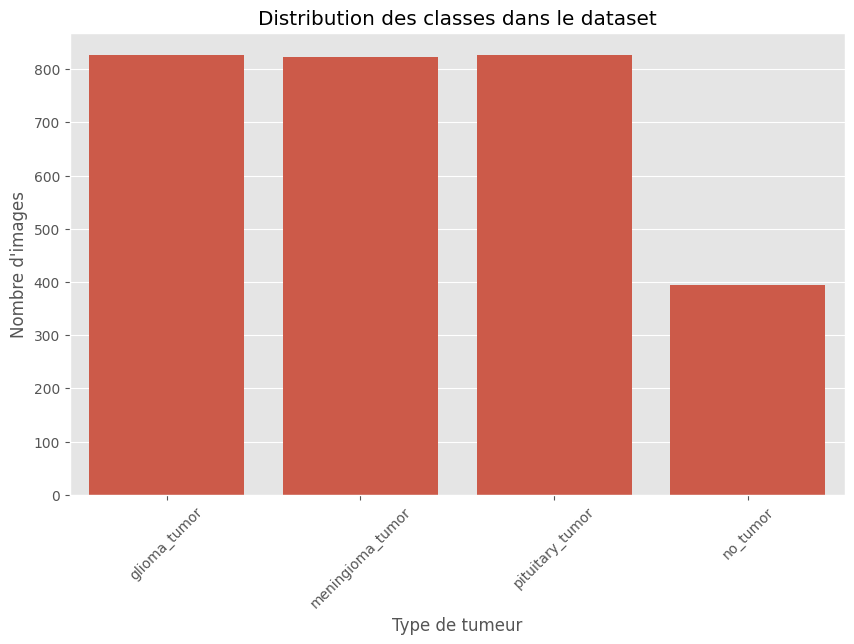


===== Image Analysis =====


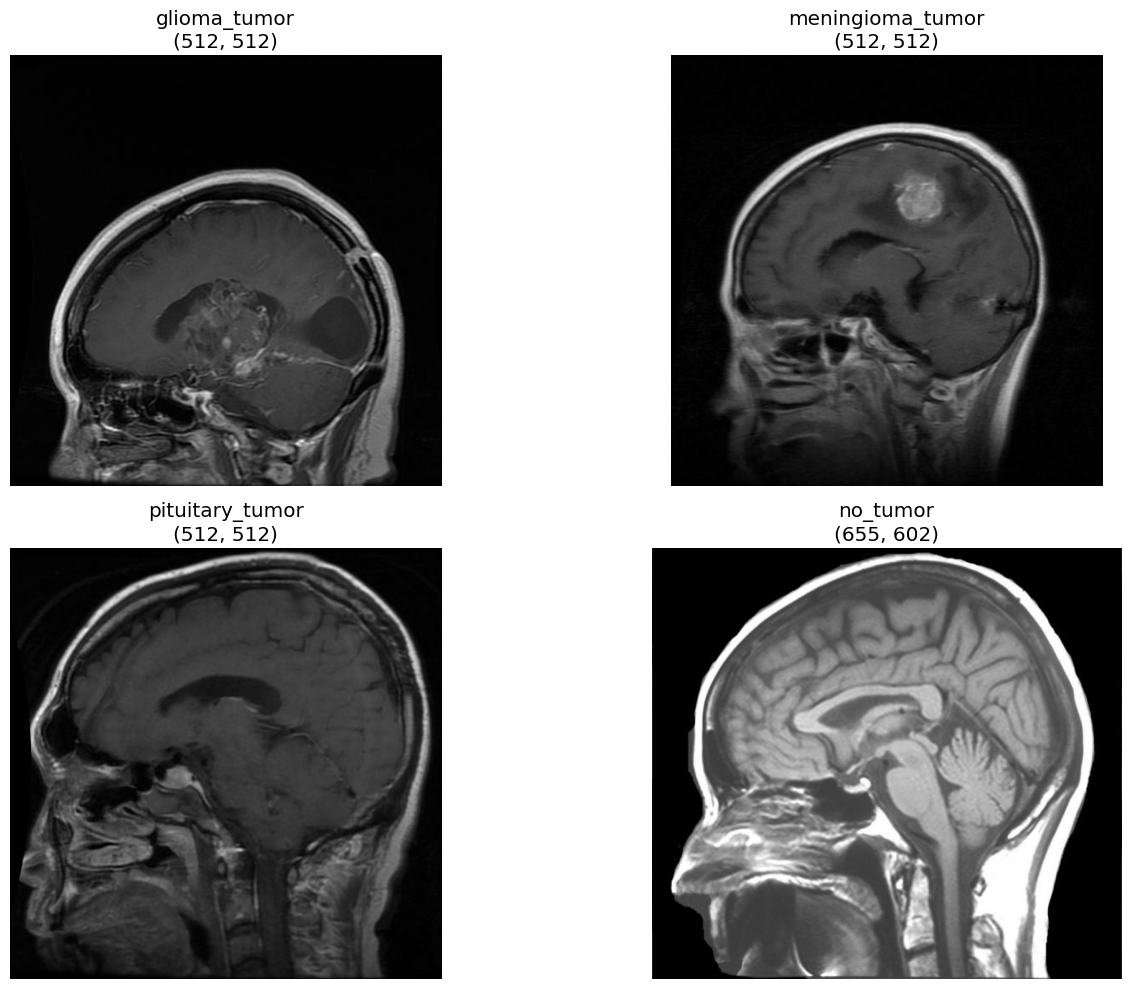


Analyse des propriétés des images:

Résumé des dimensions des images:
            width      height
count  100.000000  100.000000
mean   458.440000  462.390000
std    123.242089  118.805154
min    202.000000  202.000000
25%    512.000000  512.000000
50%    512.000000  512.000000
75%    512.000000  512.000000
max    850.000000  872.000000

Modes des images (canaux de couleur):
mode
RGB    100
Name: count, dtype: int64

===== Pixel Intensity Analysis =====


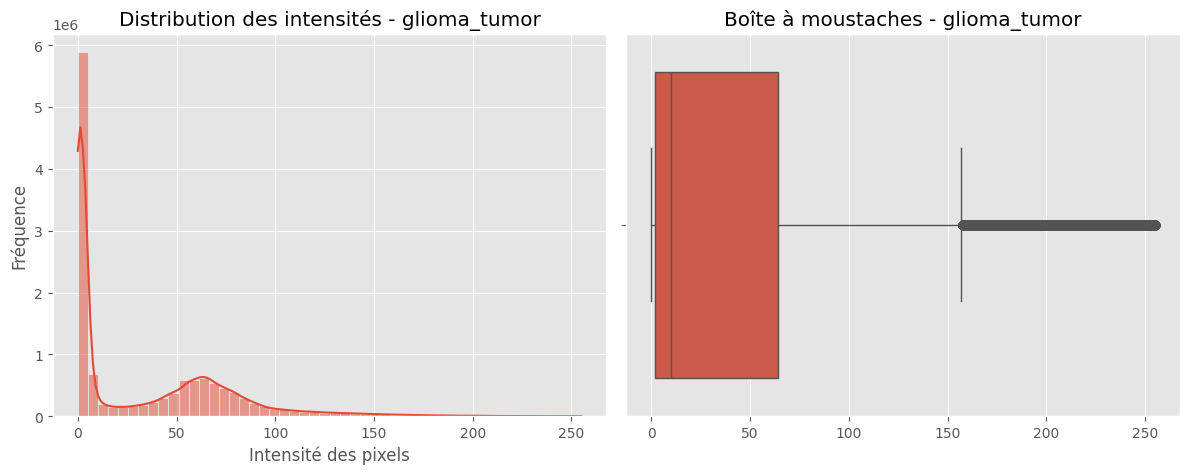

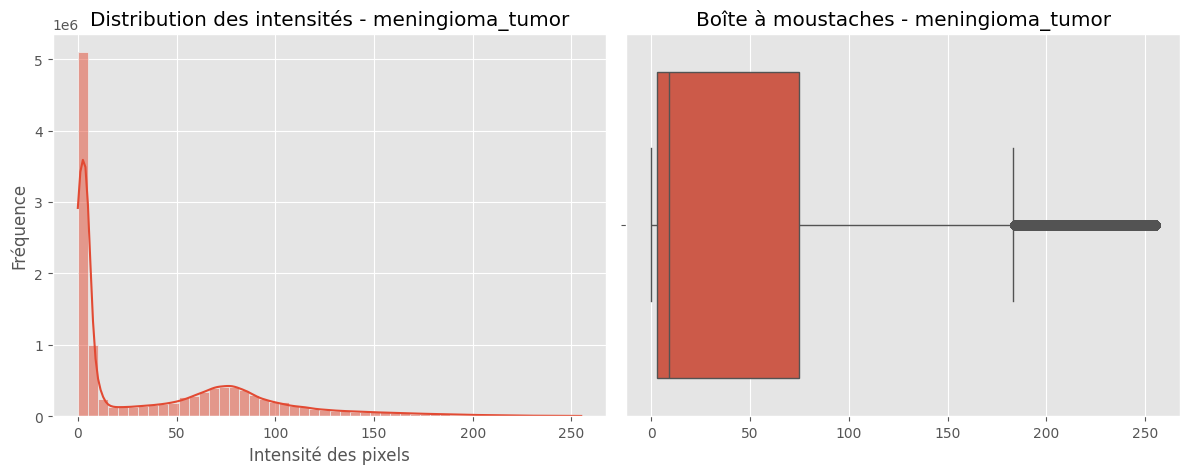

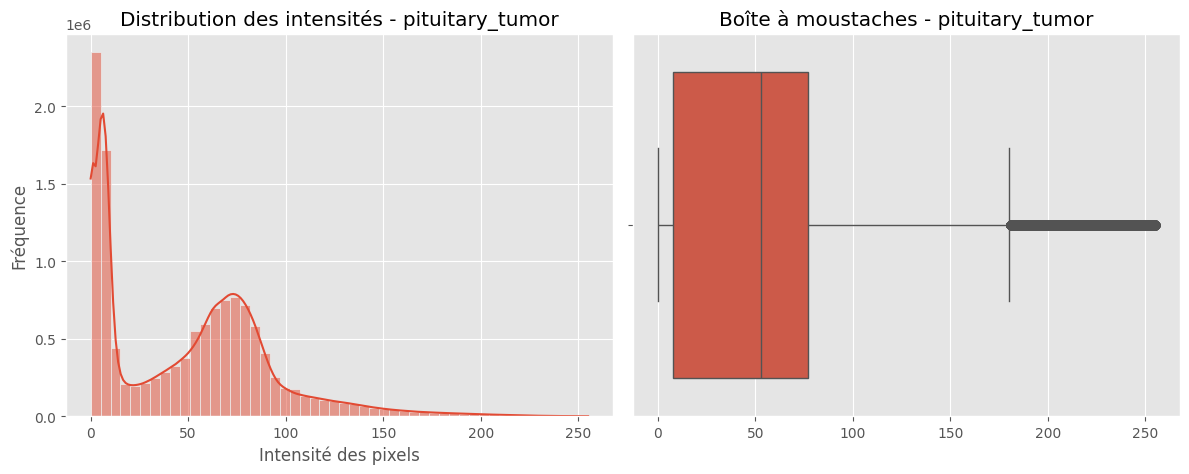

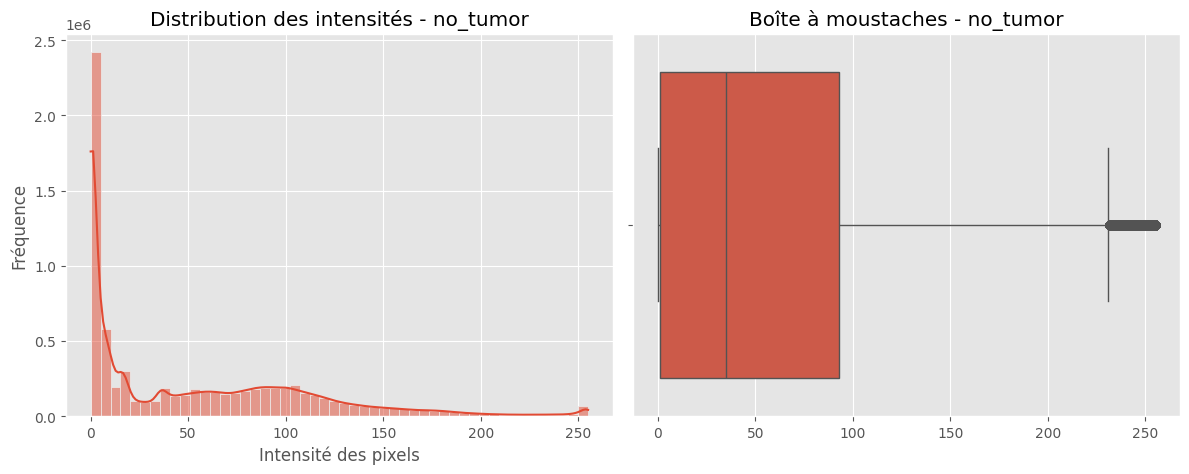


===== Additional Analysis =====

Vérification des images corrompues...
Aucune image corrompue trouvée.

===== Analysis Summary =====
Nombre total d'images: 2870
Nombre de classes: 4
Distribution des classes:
label
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
Name: count, dtype: int64


In [4]:
# Analysis des donnees: Training Set
# Ce script effectue une analyse complète du dataset d'entraînement

# Configuration de l'environnement
plt.style.use('ggplot')  # Style de visualisation
# Affichage des graphiques dans le notebook
%matplotlib inline

# Définition des chemins
data_dir = '/content/Training'  # Chemin vers le dataset d'entraînement
classes = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']  # Classes disponibles

# ======================
# 1. Analyse de la structure des données
# ======================
print("===== Data Structure Analysis =====")
# Initialisation des variables pour le comptage
class_counts = {}  # Dictionnaire pour stocker le nombre d'images par classe
image_paths = []   # Liste des chemins des images
labels = []        # Liste des labels correspondants

# Parcours de chaque classe pour compter les images
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    count = len(os.listdir(class_dir))  # Compte des images dans le dossier
    class_counts[class_name] = count

    # Collecte des chemins d'images et des labels
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

# Création d'un DataFrame pour faciliter l'analyse
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Affichage de la distribution des classes
print("\nClass Distribution:")
print(pd.Series(class_counts).to_string())

# Visualisation de la distribution des classes
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Distribution des classes dans le dataset')
plt.xlabel('Type de tumeur')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=45)
plt.show()

# ======================
# 2. Analyse des images
# ======================
print("\n===== Image Analysis =====")
# Affichage d'exemples d'images pour chaque classe
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    # Sélection aléatoire d'une image dans la classe
    class_dir = os.path.join(data_dir, class_name)
    sample_img = np.random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, sample_img)

    # Lecture et affichage de l'image
    img = Image.open(img_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{class_name}\n{img.size}')  # Affiche la classe et la taille
    plt.axis('off')

plt.tight_layout()
plt.show()

# Analyse des dimensions et canaux des images
print("\nAnalyse des propriétés des images:")
image_props = []

# Échantillonnage de 100 images pour l'analyse
for img_path in df['image_path'].sample(100):
    img = Image.open(img_path)
    image_props.append({
        'width': img.size[0],   # Largeur de l'image
        'height': img.size[1],  # Hauteur de l'image
        'mode': img.mode        # Mode couleur (RGB, grayscale, etc.)
    })

# Création d'un DataFrame pour l'analyse
image_props_df = pd.DataFrame(image_props)
print("\nRésumé des dimensions des images:")
print(image_props_df[['width', 'height']].describe())

print("\nModes des images (canaux de couleur):")
print(image_props_df['mode'].value_counts())

# ======================
# 3. Analyse des intensités de pixels
# ======================
print("\n===== Pixel Intensity Analysis =====")
# Fonction pour analyser les intensités de pixels
def analyze_pixel_intensities(img_paths, title):
    intensities = []
    # Analyse des 50 premières images pour des raisons de performance
    for img_path in img_paths[:50]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            intensities.extend(img.flatten())  # Mise à plat de la matrice de pixels

    # Visualisation de la distribution des intensités
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(intensities, bins=50, kde=True)
    plt.title(f'Distribution des intensités - {title}')
    plt.xlabel('Intensité des pixels')
    plt.ylabel('Fréquence')

    # Boîte à moustaches des intensités
    plt.subplot(1, 2, 2)
    sns.boxplot(x=intensities)
    plt.title(f'Boîte à moustaches - {title}')
    plt.tight_layout()
    plt.show()

# Analyse des intensités pour chaque classe
for class_name in classes:
    class_images = df[df['label'] == class_name]['image_path'].values
    analyze_pixel_intensities(class_images, class_name)

# ======================
# 4. Analyses complémentaires
# ======================
print("\n===== Additional Analysis =====")
# Vérification des images corrompues
print("\nVérification des images corrompues...")
corrupted = []
for img_path in df['image_path']:
    try:
        img = Image.open(img_path)
        img.verify()  # Vérification de l'intégrité de l'image
    except (IOError, SyntaxError) as e:
        corrupted.append(img_path)

if corrupted:
    print(f"Nombre d'images corrompues trouvées: {len(corrupted)}")
    for path in corrupted[:5]:  # Affichage des 5 premières images corrompues
        print(path)
else:
    print("Aucune image corrompue trouvée.")

# ======================
# Résumé de l'analyse
# ======================
print("\n===== Analysis Summary =====")
print(f"Nombre total d'images: {len(df)}")
print(f"Nombre de classes: {len(classes)}")
print("Distribution des classes:")
print(df['label'].value_counts())

===== Data Structure Analysis =====

Class Distribution:
glioma_tumor        100
meningioma_tumor    115
pituitary_tumor      74
no_tumor            105


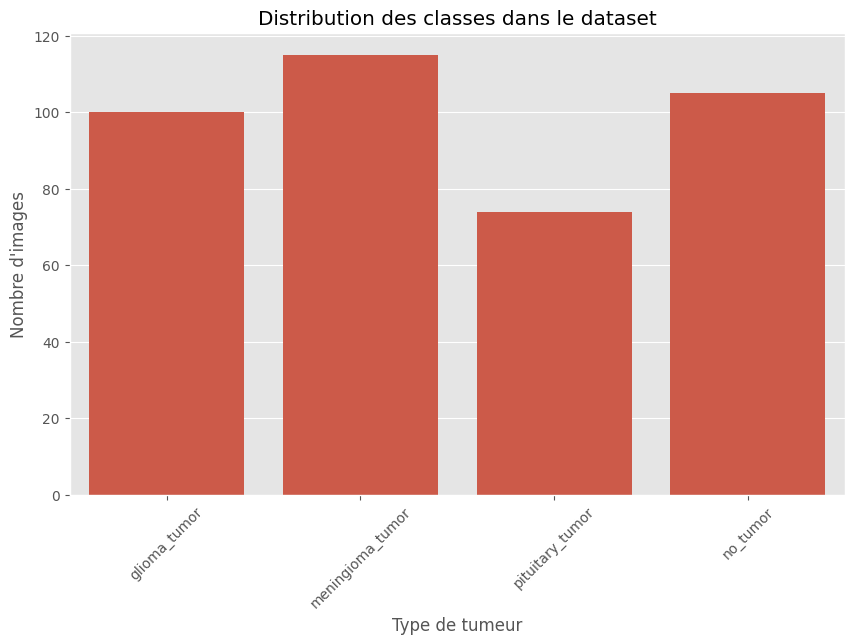


===== Image Analysis =====


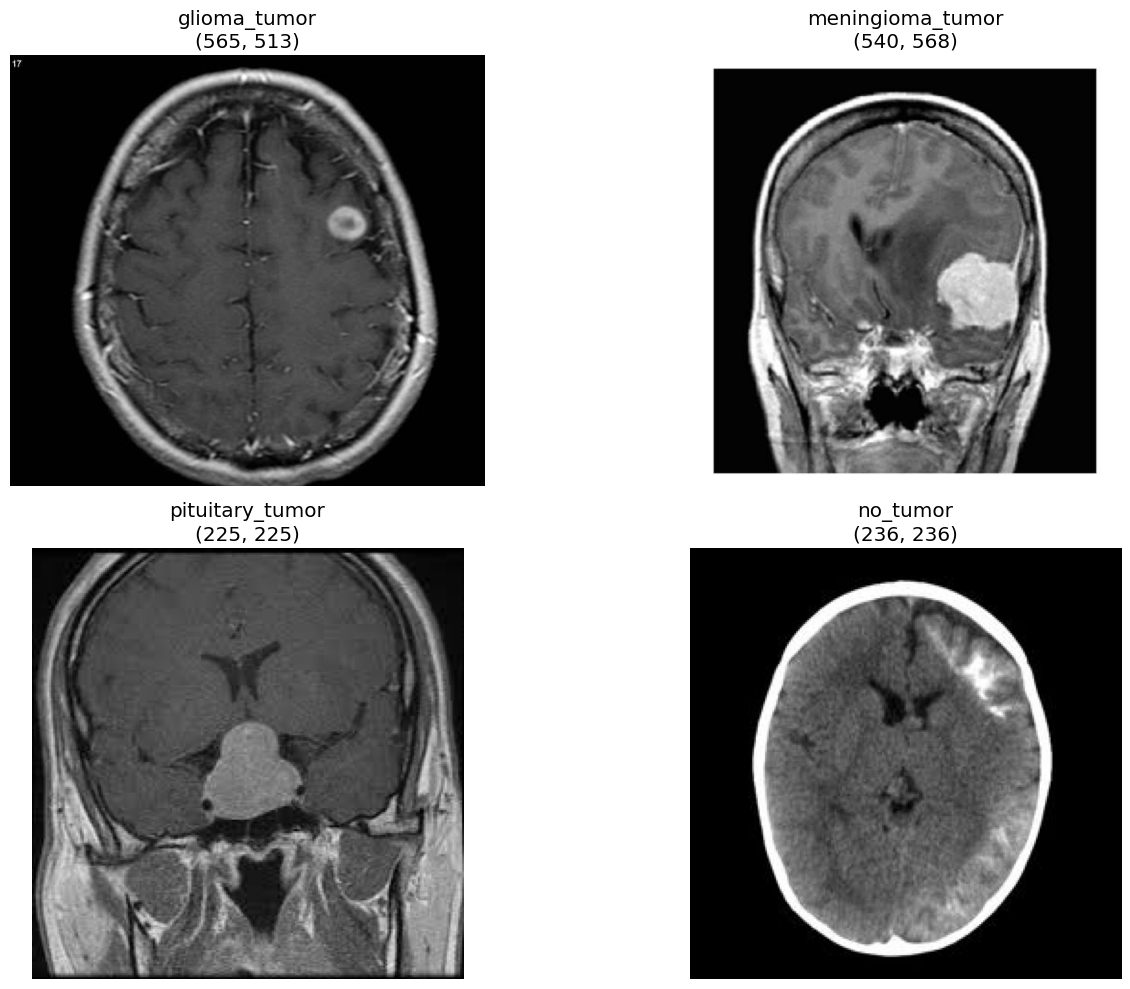


Analyse des propriétés des images:

Résumé des dimensions des images:
             width       height
count   100.000000   100.000000
mean    374.300000   384.080000
std     222.817518   210.032065
min     200.000000   210.000000
25%     234.000000   236.000000
50%     295.500000   318.500000
75%     502.000000   485.000000
max    1358.000000  1322.000000

Modes des images (canaux de couleur):
mode
RGB    100
Name: count, dtype: int64

===== Pixel Intensity Analysis =====


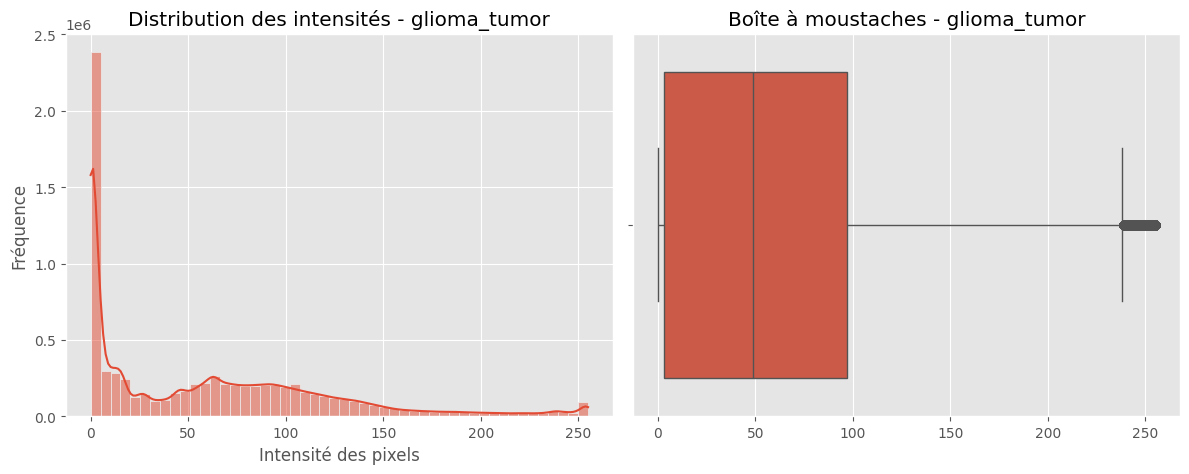

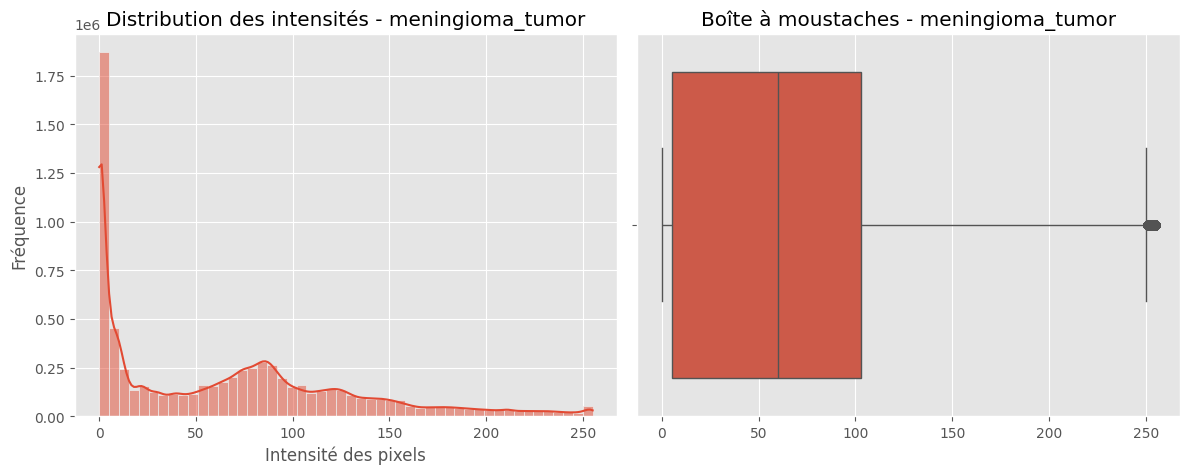

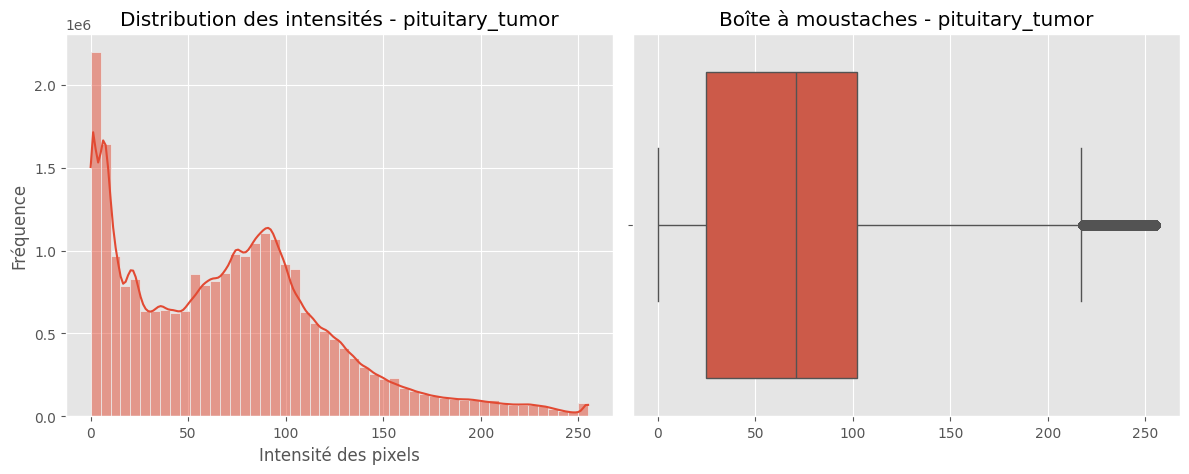

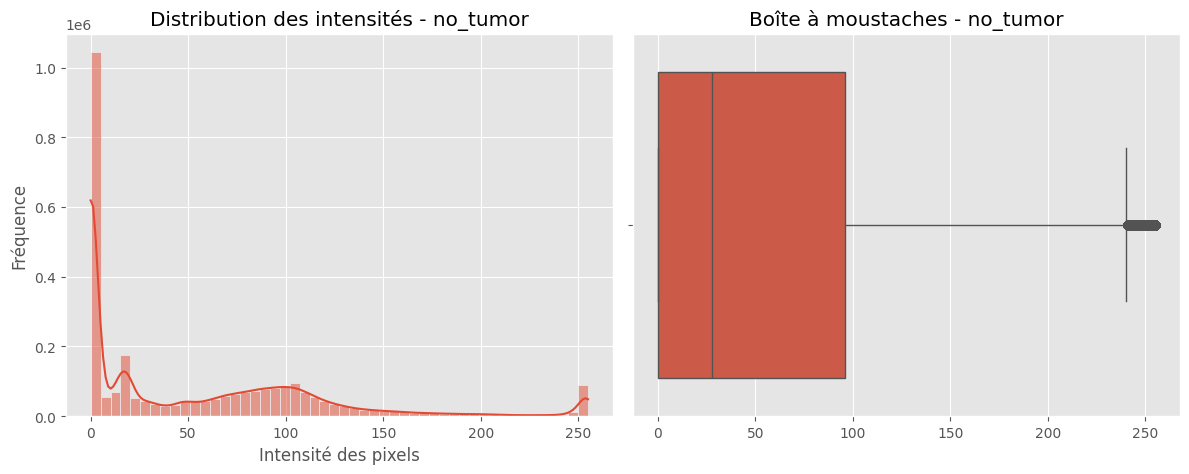


===== Additional Analysis =====

Vérification des images corrompues...
Aucune image corrompue trouvée.

===== Analysis Summary =====
Nombre total d'images: 394
Nombre de classes: 4
Distribution des classes:
label
meningioma_tumor    115
no_tumor            105
glioma_tumor        100
pituitary_tumor      74
Name: count, dtype: int64


In [5]:
# Analysis des donnees: Training Set
# Ce script effectue une analyse complète du dataset de Test

# Configuration de l'environnement
plt.style.use('ggplot')  # Style de visualisation
# Affichage des graphiques dans le notebook
%matplotlib inline

# Définition des chemins
data_dir = '/content/Testing'  # Chemin vers le dataset de test
classes = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']  # Classes disponibles

# ======================
# 1. Analyse de la structure des données
# ======================
print("===== Data Structure Analysis =====")
# Initialisation des variables pour le comptage
class_counts = {}  # Dictionnaire pour stocker le nombre d'images par classe
image_paths = []   # Liste des chemins des images
labels = []        # Liste des labels correspondants

# Parcours de chaque classe pour compter les images
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    count = len(os.listdir(class_dir))  # Compte des images dans le dossier
    class_counts[class_name] = count

    # Collecte des chemins d'images et des labels
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

# Création d'un DataFrame pour faciliter l'analyse
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Affichage de la distribution des classes
print("\nClass Distribution:")
print(pd.Series(class_counts).to_string())

# Visualisation de la distribution des classes
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Distribution des classes dans le dataset')
plt.xlabel('Type de tumeur')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=45)
plt.show()

# ======================
# 2. Analyse des images
# ======================
print("\n===== Image Analysis =====")
# Affichage d'exemples d'images pour chaque classe
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    # Sélection aléatoire d'une image dans la classe
    class_dir = os.path.join(data_dir, class_name)
    sample_img = np.random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, sample_img)

    # Lecture et affichage de l'image
    img = Image.open(img_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{class_name}\n{img.size}')  # Affiche la classe et la taille
    plt.axis('off')

plt.tight_layout()
plt.show()

# Analyse des dimensions et canaux des images
print("\nAnalyse des propriétés des images:")
image_props = []

# Échantillonnage de 100 images pour l'analyse
for img_path in df['image_path'].sample(100):
    img = Image.open(img_path)
    image_props.append({
        'width': img.size[0],   # Largeur de l'image
        'height': img.size[1],  # Hauteur de l'image
        'mode': img.mode        # Mode couleur (RGB, grayscale, etc.)
    })

# Création d'un DataFrame pour l'analyse
image_props_df = pd.DataFrame(image_props)
print("\nRésumé des dimensions des images:")
print(image_props_df[['width', 'height']].describe())

print("\nModes des images (canaux de couleur):")
print(image_props_df['mode'].value_counts())

# ======================
# 3. Analyse des intensités de pixels
# ======================
print("\n===== Pixel Intensity Analysis =====")
# Fonction pour analyser les intensités de pixels
def analyze_pixel_intensities(img_paths, title):
    intensities = []
    # Analyse des 50 premières images pour des raisons de performance
    for img_path in img_paths[:50]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            intensities.extend(img.flatten())  # Mise à plat de la matrice de pixels

    # Visualisation de la distribution des intensités
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(intensities, bins=50, kde=True)
    plt.title(f'Distribution des intensités - {title}')
    plt.xlabel('Intensité des pixels')
    plt.ylabel('Fréquence')

    # Boîte à moustaches des intensités
    plt.subplot(1, 2, 2)
    sns.boxplot(x=intensities)
    plt.title(f'Boîte à moustaches - {title}')
    plt.tight_layout()
    plt.show()

# Analyse des intensités pour chaque classe
for class_name in classes:
    class_images = df[df['label'] == class_name]['image_path'].values
    analyze_pixel_intensities(class_images, class_name)

# ======================
# 4. Analyses complémentaires
# ======================
print("\n===== Additional Analysis =====")
# Vérification des images corrompues
print("\nVérification des images corrompues...")
corrupted = []
for img_path in df['image_path']:
    try:
        img = Image.open(img_path)
        img.verify()  # Vérification de l'intégrité de l'image
    except (IOError, SyntaxError) as e:
        corrupted.append(img_path)

if corrupted:
    print(f"Nombre d'images corrompues trouvées: {len(corrupted)}")
    for path in corrupted[:5]:  # Affichage des 5 premières images corrompues
        print(path)
else:
    print("Aucune image corrompue trouvée.")

# ======================
# Résumé de l'analyse
# ======================
print("\n===== Analysis Summary =====")
print(f"Nombre total d'images: {len(df)}")
print(f"Nombre de classes: {len(classes)}")
print("Distribution des classes:")
print(df['label'].value_counts())

Facteurs d'augmentation par classe:
glioma_tumor: 1x
meningioma_tumor: 1x
pituitary_tumor: 1x
no_tumor: 2x

Répartition des données:
Ensemble d'entraînement: 2439 images
Ensemble de validation: 431 images
Ensemble de test: 394 images


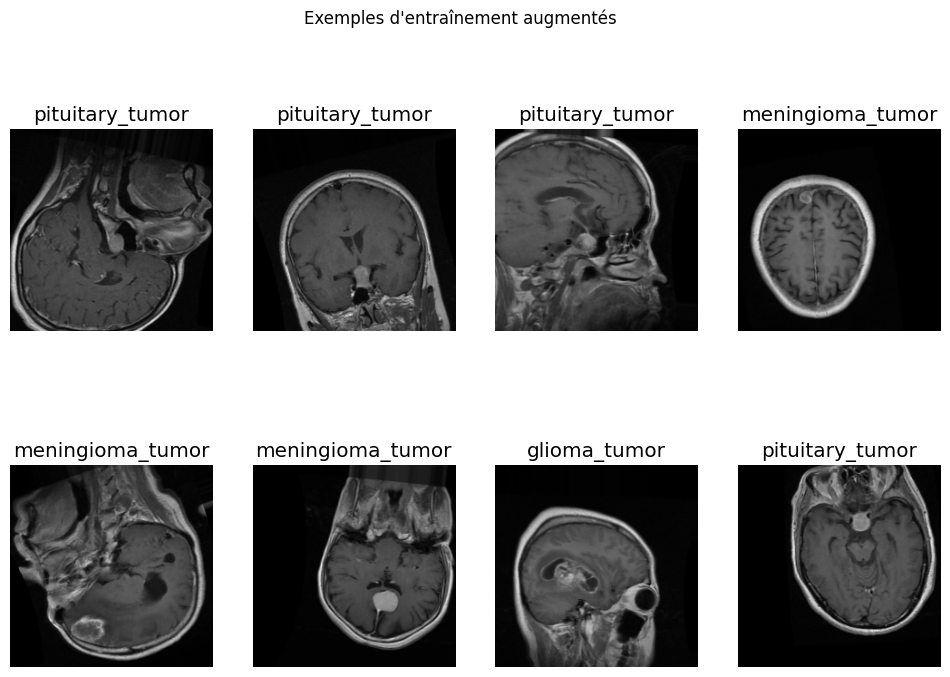

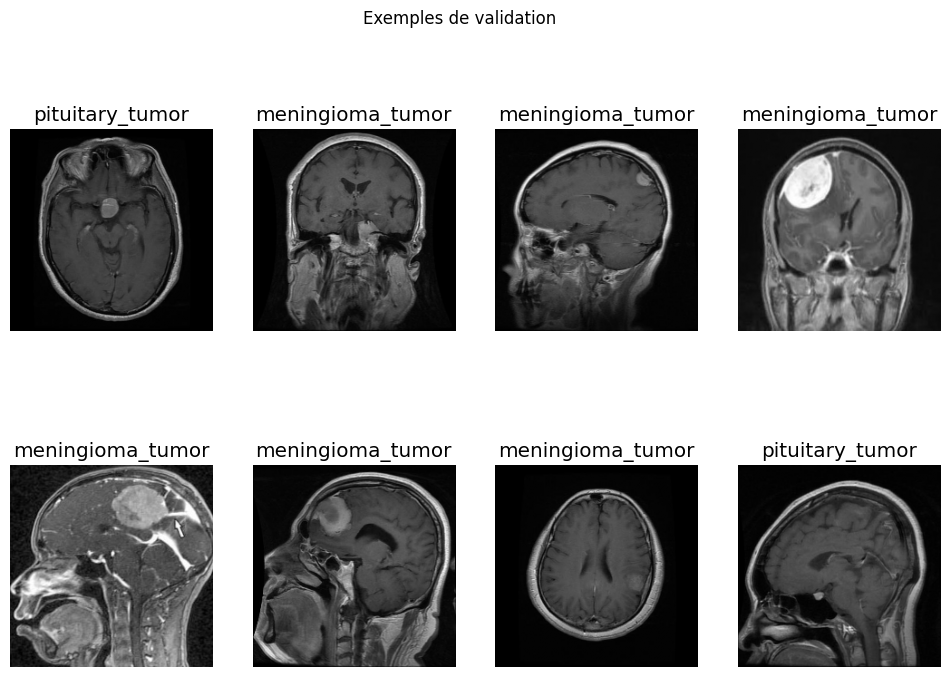

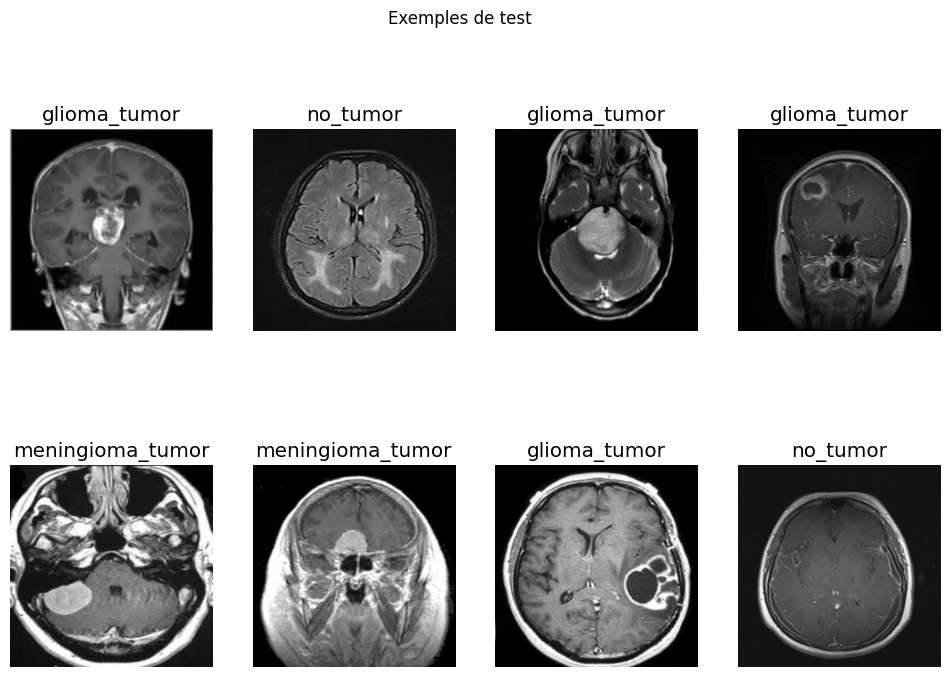


Prétraitement terminé. Noms des classes sauvegardés dans /content/preprocessed_data


In [13]:
# Analyse et prétraitement des données pour la classification de tumeurs cérébrales

# Fixer la graine aléatoire pour la reproductibilité
np.random.seed(42)

# ======================================
# 1. Définition des chemins et paramètres
# ======================================
train_dir = '/content/Training'  # Chemin vers les données d'entraînement
test_dir = '/content/Testing'    # Chemin vers les données de test
output_dir = '/content/preprocessed_data'  # Répertoire pour sauvegarder les données prétraitées

# Paramètres du modèle
IMG_SIZE = (224, 224)  # Taille standard pour les modèles ViT/CNN
BATCH_SIZE = 64       # Taille des lots pour l'entraînement
VAL_SPLIT = 0.15       # 15% des données d'entraînement pour la validation


# ======================================
# 2. Gestion du déséquilibre des classes
# ======================================
# Compte des images par classe (exemple avec des valeurs prédéfinies)
class_counts = {
    'glioma_tumor': 826,
    'meningioma_tumor': 822,
    'pituitary_tumor': 827,
    'no_tumor': 395  # Classe sous-représentée
}

# Calcul des facteurs d'augmentation pour équilibrer les classes
max_count = max(class_counts.values())
augmentation_factors = {
    cls: max_count // count for cls, count in class_counts.items()
}

print("Facteurs d'augmentation par classe:")
for cls, factor in augmentation_factors.items():
    print(f"{cls}: {factor}x")

# ======================================
# 3. Création des DataFrames pour les données
# ======================================
def create_dataframe(data_dir):
    """Crée un DataFrame avec les chemins des images et leurs labels"""
    image_paths = []
    labels = []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        for img_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(label)
    return pd.DataFrame({'image_path': image_paths, 'label': labels})

# Création des DataFrames pour l'entraînement et le test
train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

# ======================================
# 4. Séparation entraînement-validation
# ======================================
# Division stratifiée pour conserver les proportions de classes
train_df, val_df = train_test_split(
    train_df,
    test_size=VAL_SPLIT,
    stratify=train_df['label'],  # Conservation des proportions
    random_state=42
)

print("\nRépartition des données:")
print(f"Ensemble d'entraînement: {len(train_df)} images")
print(f"Ensemble de validation: {len(val_df)} images")
print(f"Ensemble de test: {len(test_df)} images")

# ======================================
# 5. Fonctions de prétraitement
# ======================================
def preprocess_image(image_path, img_size=IMG_SIZE):
    """Charge et prétraite une image"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Conversion en RGB
    img = cv2.resize(img, img_size)             # Redimensionnement
    img = img / 255.0                           # Normalisation [0,1]
    return img

def apply_augmentation(image, label):
    """Applique une augmentation d'image adaptée à la classe"""
    if label == 'no_tumor':
        # Augmentation plus forte pour la classe minoritaire
        datagen = ImageDataGenerator(
            rotation_range=40,      # Rotation jusqu'à 30 degrés
            width_shift_range=0.3,  # Déplacement horizontal aléatoire
            height_shift_range=0.3, # Déplacement vertical aléatoire
            shear_range=0.3,        # Cisaillement
            zoom_range=0.3,         # Zoom aléatoire
            horizontal_flip=True,   # Retournement horizontal
            vertical_flip=True,      # Retournement vertical
            brightness_range=[0.7,1.3],
            fill_mode='constant',     # Remplissage des bords
            cval=0                    # Valeur de remplissage (noir)
        )
    else:
        # Augmentation standard pour les autres classes
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.15,
            height_shift_range=0.15,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )

    # Application de la transformation aléatoire
    augmented = datagen.random_transform(image)
    return augmented

# ======================================
# 6. Création des pipelines de données TensorFlow
# ======================================
# Encodage des labels en valeurs numériques
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])
val_df['encoded_label'] = label_encoder.transform(val_df['label'])
test_df['encoded_label'] = label_encoder.transform(test_df['label'])

# Générateur de données personnalisé
class BrainTumorDataGenerator(tf.keras.utils.Sequence):
    """Générateur de données pour l'entraînement du modèle"""
    def __init__(self, df, batch_size=BATCH_SIZE, shuffle=True, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        """Nombre de lots par époque"""
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        """Génère un lot de données"""
        batch_df = self.df[index*self.batch_size:(index+1)*self.batch_size]
        images = []
        labels = []

        for _, row in batch_df.iterrows():
            img = preprocess_image(row['image_path'])
            label = row['encoded_label']

            if self.augment:
                img = apply_augmentation(img, row['label'])

            images.append(img)
            labels.append(label)

        return np.array(images), to_categorical(labels, num_classes=4)

    def on_epoch_end(self):
        """Mélange les données à la fin de chaque époque"""
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

# Création des générateurs
train_generator = BrainTumorDataGenerator(train_df, augment=True)  # Avec augmentation
val_generator = BrainTumorDataGenerator(val_df, augment=False)    # Sans augmentation
test_generator = BrainTumorDataGenerator(test_df, augment=False)  # Sans augmentation

# ======================================
# 7. Vérification du prétraitement
# ======================================
def plot_sample_images(generator, title):
    """Affiche des exemples d'images prétraitées"""
    images, labels = generator[0]
    class_names = label_encoder.classes_

    plt.figure(figsize=(12, 8))
    for i in range(min(8, len(images))):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualisation des échantillons
plot_sample_images(train_generator, "Exemples d'entraînement augmentés")
plot_sample_images(val_generator, "Exemples de validation")
plot_sample_images(test_generator, "Exemples de test")

# ======================================
# 8. Sauvegarde des données prétraitées
# ======================================
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Sauvegarde des noms de classes
np.save(os.path.join(output_dir, 'class_names.npy'), label_encoder.classes_)
print(f"\nPrétraitement terminé. Noms des classes sauvegardés dans {output_dir}")

Shape des données du générateur: (64, 224, 224, 3)


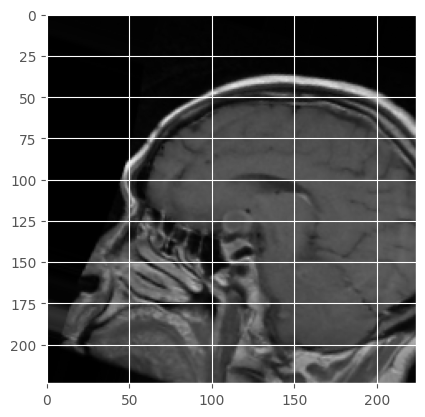

Epoch 1/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.4913 - loss: 0.9957

39/39 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.4929 - loss: 0.9929 - val_accuracy: 0.4919 - val_loss: 1.5948
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 899ms/step - accuracy: 0.6179 - loss: 0.7919 - val_accuracy: 0.4919 - val_loss: 1.6877
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.6515 - loss: 0.7475

39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 911ms/step - accuracy: 0.6514 - loss: 0.7473 - val_accuracy: 0.5313 - val_loss: 1.7523
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.6579 - loss: 0.7458

39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 880ms/step - accuracy: 0.6583 - loss: 0.7454 - val_accuracy: 0.5522 - val_loss: 1.7478
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 901ms/step - accuracy: 0.6878 - loss: 0.7052 - val_accuracy: 0.5128 - val_loss: 1.8079
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 906ms/step - accuracy: 0.6781 - loss: 0.6938 - val_accuracy: 0.5476 - val_loss: 1.8340


In [24]:
# =============================================
# 1. Définition et enregistrement de la couche Patches personnalisée
# =============================================

@utils.register_keras_serializable()  # Permet la sérialisation de la couche
class Patches(layers.Layer):
    """Couche personnalisée pour extraire des patches d'images"""

    def __init__(self, patch_size=16, **kwargs):
        """
        Initialisation de la couche
        Args:
            patch_size: Taille des patches carrés (16x16 par défaut)
            **kwargs: Arguments supplémentaires pour la classe Layer
        """
        super().__init__(**kwargs)
        self.patch_size = patch_size  # Stocke la taille des patches

    def call(self, images):
        """
        Méthode principale qui transforme les images en séquence de patches
        Args:
            images: Lot d'images en entrée (shape: [batch, H, W, C])
        Returns:
            Séquence de patches (shape: [batch, num_patches, patch_size*patch_size*3])
        """
        batch_size = tf.shape(images)[0]
        # Extraction des patches avec tf.image.extract_patches
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],  # Taille des patches
            strides=[1, self.patch_size, self.patch_size, 1], # Pas de déplacement
            rates=[1, 1, 1, 1],  # Taux d'échantillonnage
            padding="VALID"       # Pas de remplissage (padding)
        )
        # Réorganisation des dimensions pour avoir [batch, num_patches, patch_dims]
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

    def get_config(self):
        """Configuration nécessaire pour la sérialisation"""
        return {"patch_size": self.patch_size}

# =============================================
# 2. Construction du modèle ViT original (entrée 224x224)
# =============================================

def build_vit_model():
    """Construit un modèle Vision Transformer simplifié"""

    # Couche d'entrée (taille originale 224x224)
    inputs = layers.Input(shape=(224, 224, 3))

    # 1. Création des patches (16x16)
    patches = Patches(patch_size=16)(inputs)

    # 2. Projection linéaire des patches
    projection_dim = 64  # Réduit de 768 à 64 pour accélérer l'entraînement
    num_patches = (224 // 16) * (224 // 16)  # Nombre total de patches (14x14=196)

    # 3. Embeddings des patches + position
    embeddings = layers.Dense(projection_dim)(patches)  # Projection linéaire
    positions = tf.range(start=0, limit=num_patches, delta=1)  # Positions des patches
    position_embedding = layers.Embedding(num_patches, projection_dim)(positions)
    embeddings = embeddings + position_embedding  # Ajout de l'embedding positionnel

    # 4. Bloc Transformer unique (simplifié)
    # Normalisation
    x1 = layers.LayerNormalization(epsilon=1e-6)(embeddings)
    # Attention multi-têtes (2 têtes au lieu de 12)
    attention_output = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x1, x1)
    # Connexion résiduelle
    x2 = layers.Add()([attention_output, embeddings])
    # MLP (Perceptron multicouche)
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = layers.Dense(projection_dim * 2, activation="gelu")(x3)  # Expansion
    x3 = layers.Dense(projection_dim)(x3)  # Projection
    embeddings = layers.Add()([x3, x2])  # Connexion résiduelle

    # 5. Tête de classification
    x = layers.GlobalAveragePooling1D()(embeddings)  # Pooling global
    outputs = layers.Dense(4, activation="softmax")(x)  # Couche de sortie (4 classes)

    return models.Model(inputs, outputs)

# =============================================
# 3. Compilation du modèle
# =============================================

model = build_vit_model()

# Configuration de l'entraînement:
# - Optimiseur: Adam avec learning rate 3e-4
# - Loss: Entropie croisée catégorielle
# - Métrique: Accuracy
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# =============================================
# 4. Vérification du générateur de données
# =============================================

def verify_generator(generator):
    """
    Vérifie que le générateur produit des images de la bonne taille
    Args:
        generator: Générateur de données à vérifier
    """
    x, y = generator[0]  # Récupère le premier lot
    print(f"Shape des données du générateur: {x.shape}")  # Devrait être (batch_size, 224, 224, 3)
    # Affichage d'un exemple
    plt.imshow(x[0])
    plt.show()

verify_generator(train_generator)  # Vérification sur le générateur d'entraînement

# =============================================
# 5. Entraînement du modèle avec les bonnes dimensions
# =============================================

history = model.fit(
    train_generator,  # Utilisation directe du générateur
    epochs=15,       # Nombre maximum d'époques
    validation_data=val_generator,  # Générateur de validation
    callbacks=[
        # Arrêt précoce si la validation ne s'améliore pas pendant 3 époques
        tf.keras.callbacks.EarlyStopping(patience=5),
        # Sauvegarde du meilleur modèle basé sur val_accuracy
        tf.keras.callbacks.ModelCheckpoint(
            "best_model.h5",
            monitor="val_accuracy",
            save_best_only=True
        )
    ]
)

Using the last trained model for evaluation.

=== Creating Evaluation Generator ===

=== Running Evaluation ===
Test Accuracy: 0.3782
Test Loss: 3.2297

=== Classification Report ===
                  precision    recall  f1-score   support

    glioma_tumor       0.40      0.21      0.27       100
meningioma_tumor       0.38      0.65      0.48       115
        no_tumor       0.00      0.00      0.00       105
 pituitary_tumor       0.37      0.72      0.49        74

        accuracy                           0.38       394
       macro avg       0.29      0.39      0.31       394
    weighted avg       0.28      0.38      0.30       394


=== Confusion Matrix ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


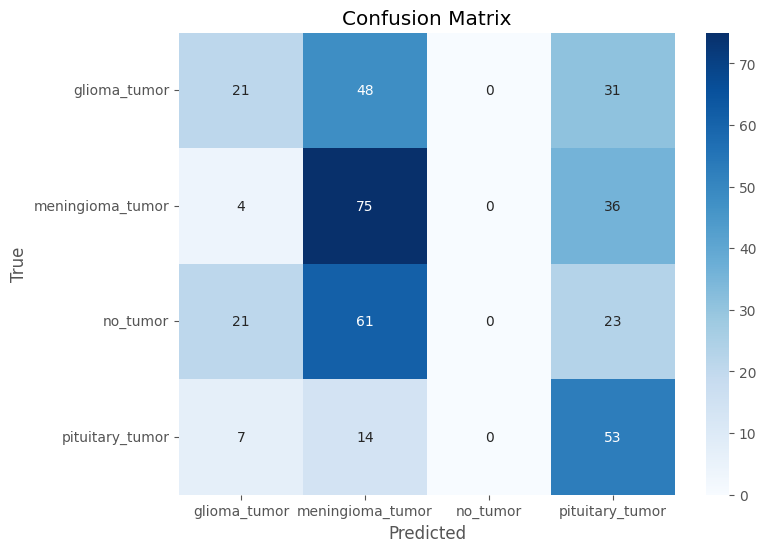


=== Training History ===


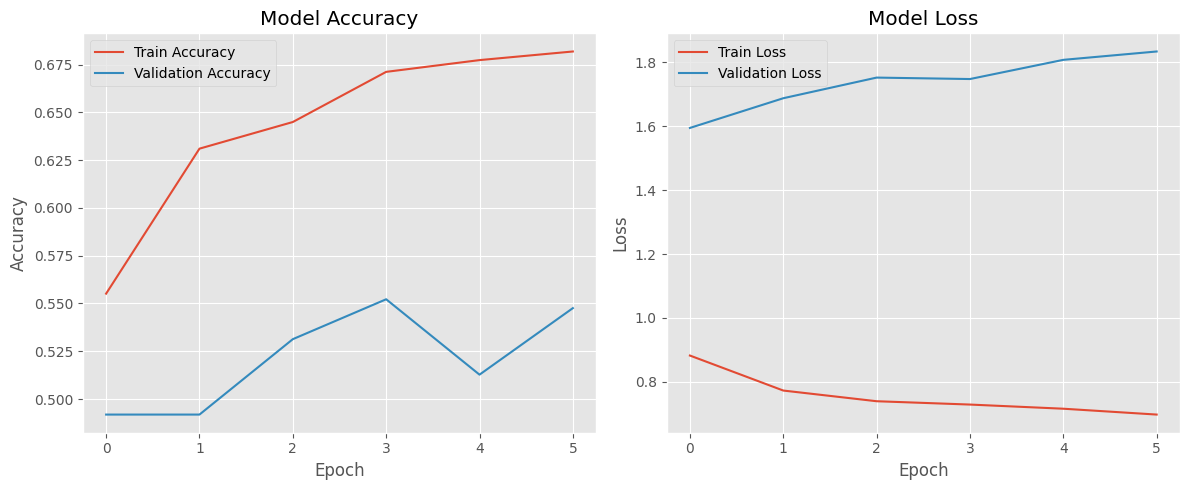


=== Additional Metrics ===
Weighted Precision: 0.2807
Weighted Recall: 0.3782
Weighted F1-Score: 0.3013

=== Per-Class Metrics ===
glioma_tumor - Accuracy: 0.2100
meningioma_tumor - Accuracy: 0.6522
no_tumor - Accuracy: 0.0000
pituitary_tumor - Accuracy: 0.7162


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# ======================================
# Robust Model Evaluation
# ======================================

# 1. Load the model (with custom layer handling)
try:
    model = tf.keras.models.load_model("best_model.h5",
                                     custom_objects={'Patches': Patches})
    print("Loaded best saved model for evaluation.")
except:
    print("Using the last trained model for evaluation.")

# 2. Create a new evaluation generator (fresh instance)
print("\n=== Creating Evaluation Generator ===")
eval_generator = BrainTumorDataGenerator(test_df, batch_size=32, augment=False)

# 3. Manual evaluation function
def evaluate_model(model, generator):
    y_true = []
    y_pred = []
    total_loss = 0
    total_acc = 0
    num_batches = int(np.ceil(len(generator.df) / generator.batch_size))

    for i in range(num_batches):
        # Get batch
        x, y = generator[i]

        # Evaluate
        batch_loss, batch_acc = model.evaluate(x, y, verbose=0)
        total_loss += batch_loss * len(x)
        total_acc += batch_acc * len(x)

        # Predict
        batch_pred = model.predict(x, verbose=0)
        y_true.extend(np.argmax(y, axis=1))
        y_pred.extend(np.argmax(batch_pred, axis=1))

    # Calculate averages
    avg_loss = total_loss / len(generator.df)
    avg_acc = total_acc / len(generator.df)

    return avg_loss, avg_acc, y_true, y_pred

# 4. Run evaluation
print("\n=== Running Evaluation ===")
test_loss, test_acc, y_true, y_pred = evaluate_model(model, eval_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 5. Classification Report
print("\n=== Classification Report ===")
class_names = label_encoder.classes_
print(classification_report(y_true, y_pred, target_names=class_names))

# 6. Confusion Matrix
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 7. Training History Plot
if 'history' in locals():
    print("\n=== Training History ===")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 8. Additional Metrics
print("\n=== Additional Metrics ===")
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

# 9. Per-Class Metrics
print("\n=== Per-Class Metrics ===")
cm = confusion_matrix(y_true, y_pred)
class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_acc):
    print(f"{class_names[i]} - Accuracy: {acc:.4f}")